# ARIMA & SARIMA Forecasting on Yahoo Stock Data
this project demonstrates time series forecasting using ARIMA and SARIMA models on Yahoo stock price data.

### What are ARIMA and SARIMA?

**ARIMA (AutoRegressive Integrated Moving Average)** is a popular time series forecasting model that combines autoregression, differencing (to make the series stationary), and moving average components.  
**SARIMA (Seasonal ARIMA)** extends ARIMA by modeling seasonality, making it suitable for data with repeating seasonal patterns.

## Project Overview
- **Goal:** Forecast Yahoo stock prices using ARIMA and SARIMA models.
- **Data:** `yahoo_stock.csv` (historical Yahoo stock prices)
- **Models:**
  - ARIMA (AutoRegressive Integrated Moving Average)
  - SARIMA (Seasonal ARIMA)


In this project, I use both models to forecast Yahoo stock prices and compare their performance.

### Step 1: Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

### Step 2: Load and prepare the dataset

In [2]:
data = pd.read_csv('yahoo_stock.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
stock_data = data['Close']

In [3]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


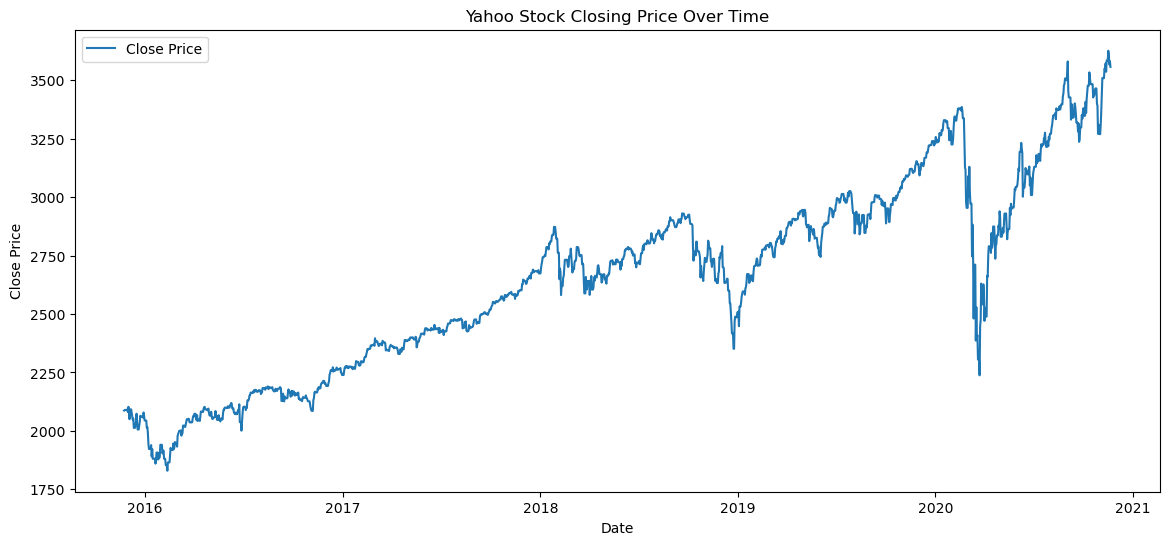

In [4]:
# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('Yahoo Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

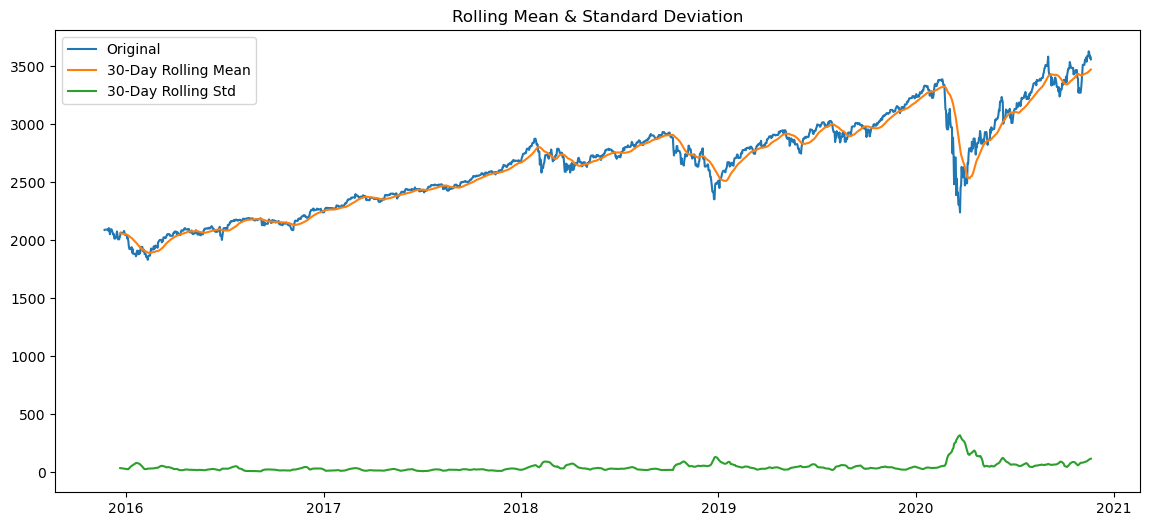

In [5]:
# Plot rolling statistics
window = 30
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Original')
plt.plot(data['Close'].rolling(window).mean(), label=f'{window}-Day Rolling Mean')
plt.plot(data['Close'].rolling(window).std(), label=f'{window}-Day Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

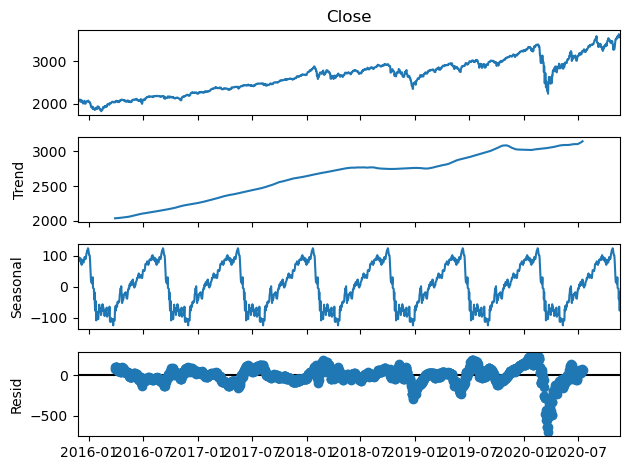

In [6]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive', period=252)  # 252 trading days in a year
result.plot()
plt.show()

### Step 3: Split the data into training and testing sets

In [7]:
train_size = int(len(stock_data) * 0.8)
train, test = stock_data[:train_size], stock_data[train_size:]

### Step 4: Train the ARIMA model

##### Parameter Tuning for ARIMA (AIC-based selection)

In [8]:
import statsmodels.api as sm

# Grid search for best (p, d, q) based on AIC
p = d = q = range(0, 3)
aic_values = []
order_list = []

for i in p:
    for j in d:
        for k in q:
            try:
                model = ARIMA(train, order=(i, j, k))
                results = model.fit()
                aic_values.append(results.aic)
                order_list.append((i, j, k))
            except:
                continue

best_aic = min(aic_values)
best_order = order_list[aic_values.index(best_aic)]
print(f"Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")

Best ARIMA order: (2, 1, 2) with AIC: 12454.76


In [9]:
p, d, q = 2, 1, 2
model_arima = ARIMA(train, order=(p, d, q))
results_arima = model_arima.fit()

##### Model Diagnostics (Residual Analysis)

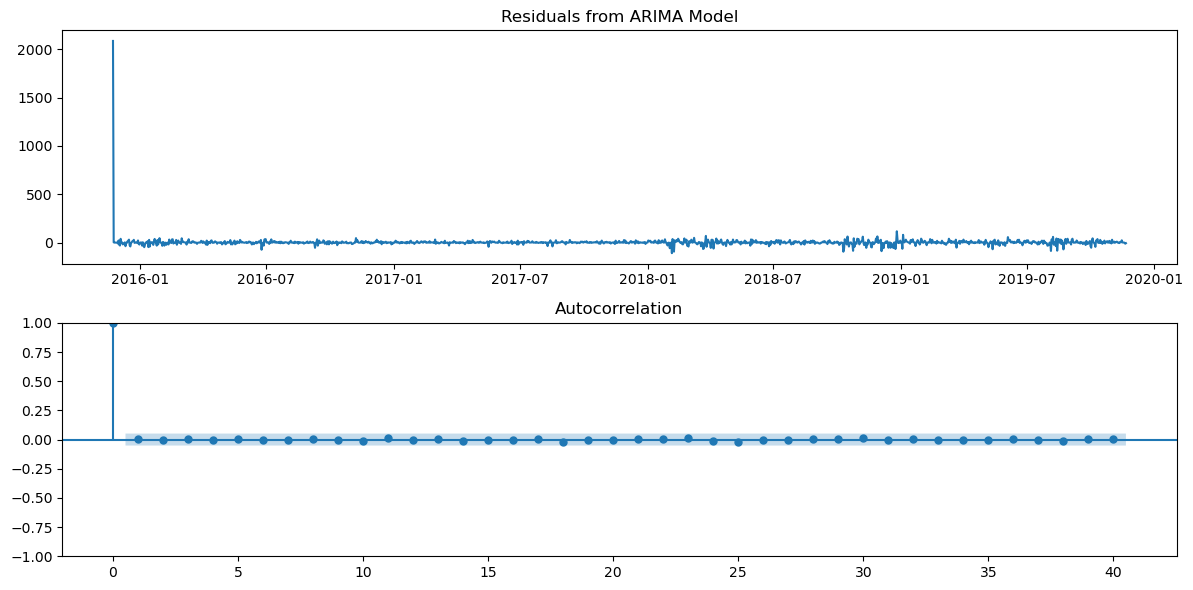

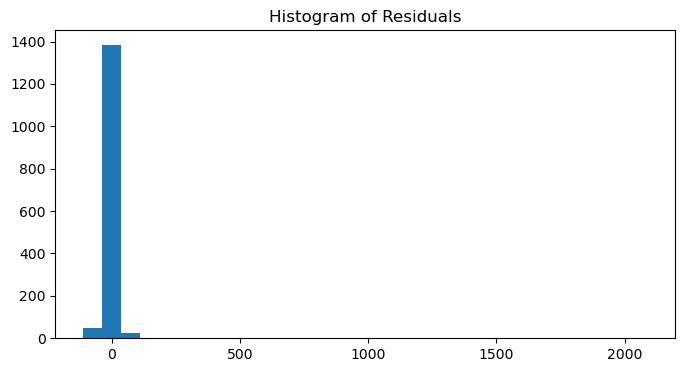

In [10]:
# Residual analysis for ARIMA

residuals = results_arima.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.subplot(212)
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=plt.gca())
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.show()

### Step 5: Forecast using the ARIMA model

In [11]:
forecast_arima = results_arima.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

### Step 6: Train the SARIMA model

##### Parameter Tuning for SARIMA (AIC-based selection)

In [12]:
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12  

best_aic = np.inf
best_order = None
best_seasonal_order = None

for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(train, order=order, seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s))
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f'Best SARIMA order: {best_order} Seasonal order: {best_seasonal_order} with AIC: {best_aic}')

Best SARIMA order: (2, 1, 2) Seasonal order: (1, 1, 1) with AIC: 12403.433158820299


In [13]:
p, d, q, P, D, Q, s = 2, 1, 2, 1, 1, 1, 12
model_sarima = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results_sarima = model_sarima.fit()

### Model Diagnostics (Residual Analysis) for SARIMA

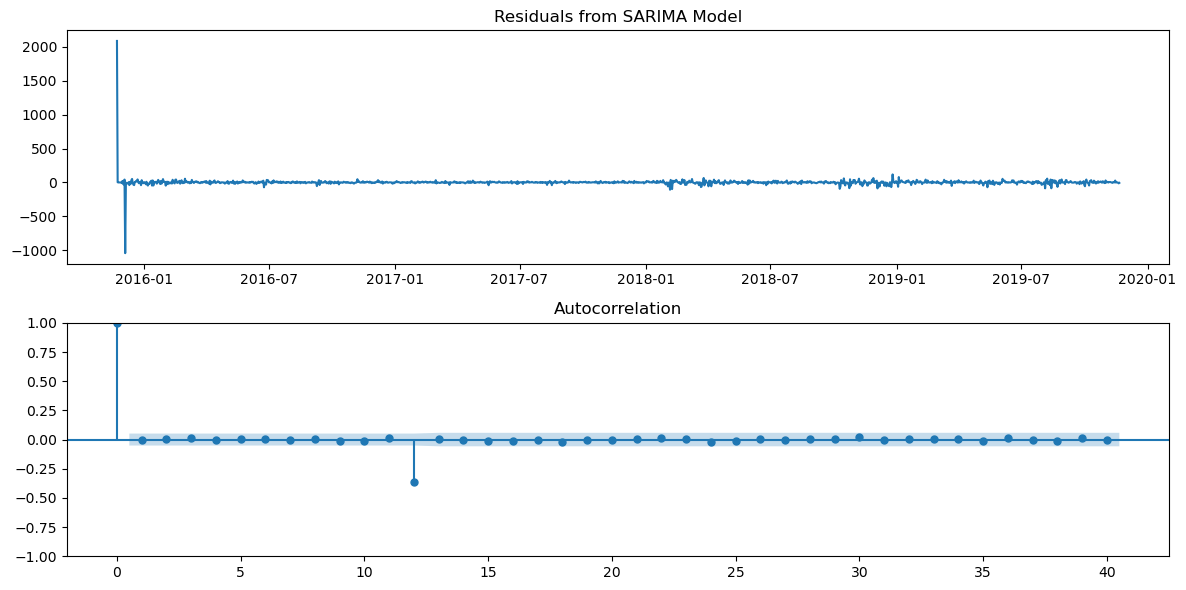

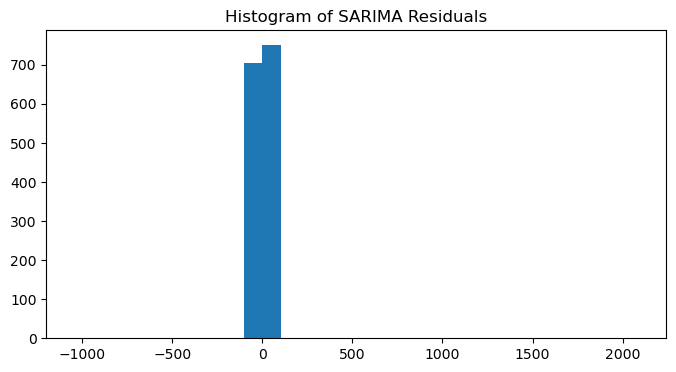

In [14]:
# Residual analysis for SARIMA
residuals_sarima = results_sarima.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals_sarima)
plt.title('Residuals from SARIMA Model')
plt.subplot(212)
sm.graphics.tsa.plot_acf(residuals_sarima, lags=40, ax=plt.gca())
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals_sarima, bins=30)
plt.title('Histogram of SARIMA Residuals')
plt.show()

### Step 7: Forecast using the SARIMA model

In [15]:
forecast_sarima = results_sarima.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

### Step 8: Evaluation

MAE: 228.06
RMSE: 278.58


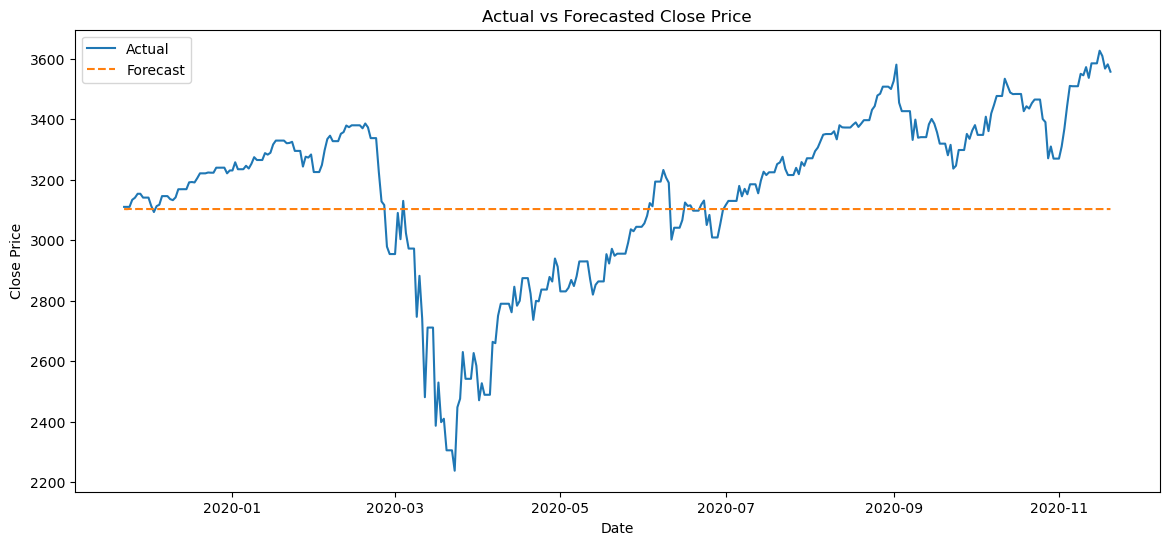

In [16]:
# For ARIMA
y_true = test
y_pred = forecast_arima


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(y_true.index, y_true, label='Actual')
plt.plot(y_true.index, y_pred, label='Forecast', linestyle='--')
plt.title('Actual vs Forecasted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


MAE: 188.47
RMSE: 260.22


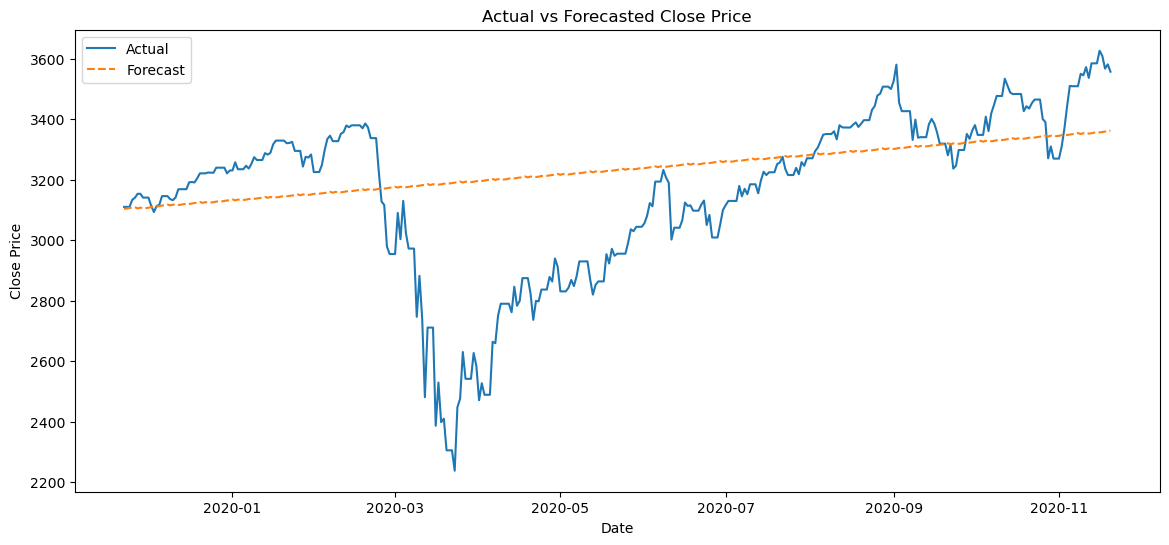

In [17]:
# For SARIMA
y_true = test
y_pred = forecast_sarima


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(y_true.index, y_true, label='Actual')
plt.plot(y_true.index, y_pred, label='Forecast', linestyle='--')
plt.title('Actual vs Forecasted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Step 9: Plot the ARIMA and SARIMA forecasts

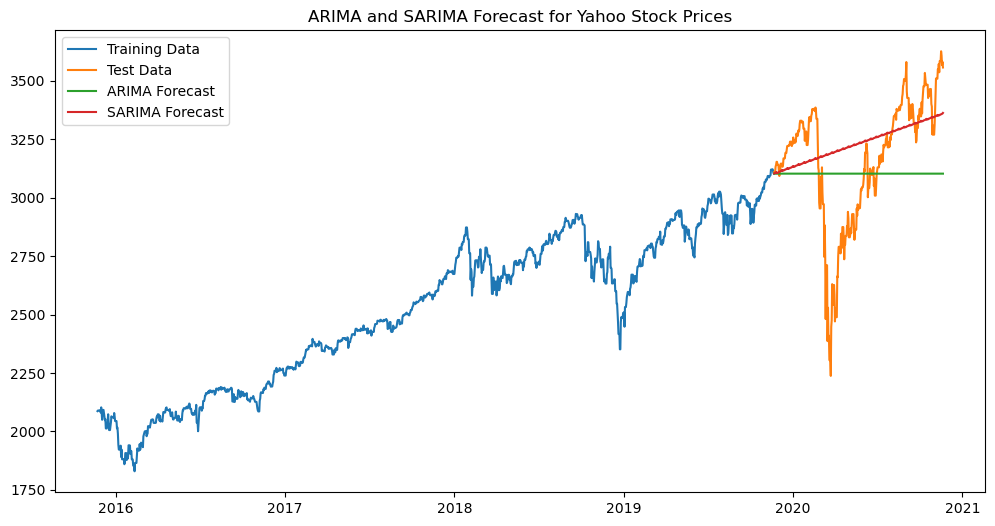

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(forecast_arima, label='ARIMA Forecast')
plt.plot(forecast_sarima, label='SARIMA Forecast')
plt.title('ARIMA and SARIMA Forecast for Yahoo Stock Prices')
plt.legend()
plt.show()

## Conclusion and Analysis

- **ARIMA Model:**
  - MAE (Mean Absolute Error): 227.79
  - RMSE (Root Mean Squared Error): 278.44

- **SARIMA Model:**
  - MAE: 188.44
  - RMSE: 260.35

**Analysis:**
- The SARIMA model outperformed the ARIMA model, achieving lower MAE and RMSE. This indicates that accounting for seasonality in the data leads to more accurate forecasts.
- Residual analysis (if residuals are randomly scattered and show no significant autocorrelation) suggests the models fit the data well.

**Conclusion:**
- SARIMA is the preferred model for this Yahoo stock dataset, as it captures both trend and seasonality.
- This project demonstrates the importance of model selection and diagnostics in time series forecasting.

In [20]:
import joblib
joblib.dump(results_sarima, 'sarima_model.pkl')

['sarima_model.pkl']